<a href="https://colab.research.google.com/github/raurica/Image-Forgery/blob/main/ImageForgery_not_KFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#импортируем необходимые библиотеки и модули

import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

In [3]:
#создаем связку с гугл диском

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##Loading the dataset

In [6]:
#загружаем конкретный файл с моего гугл диска, в данном случае это файл с архивом, в котором находится датасет

#fileId = drive.CreateFile({'id':'1pL6W3mN931TmmaCtMZsR0z1YuVfkvH4J'}) #MICC-F220.zip
#fileId = drive.CreateFile({'id':'1JDz-suK2Qy0HDTXzq8XPDRs5QmRX9e4s'}) #MICC-F600.zip
fileId = drive.CreateFile({'id':'1G5XjcONn5-TK5h_S3sPNwYxDICNWZ-8h'}) #MICC-F2000.zip 
#fileId = drive.CreateFile({'id':'1kyIfGJni8pLkegfyBRdkdv9GqeZUOX-l'}) #MICC-F220-F600-F2000.zip
fileId.GetContentFile(fileId['title'])
print('Uploaded {}, id {}'.format(fileId['title'],fileId['id']))

Uploaded MICC-F2000.zip, id 1G5XjcONn5-TK5h_S3sPNwYxDICNWZ-8h


In [19]:
#распаковываем архив с датасетом

!unzip -q MICC-F220.zip
!unzip -q MICC-F600.zip
!unzip -q MICC-F2000.zip
#!unzip -q MICC-F220-F600-F2000.zip
print('dataset unzipped')

dataset unzipped


In [25]:
import os, shutil

# current folder path
current_folder = os.getcwd() 
  
# list of folders to be merged
list_dir = ['/content/MICC-F220/test_train_images/original', '/content/MICC-F600/test_train_images/original','/content/MICC-F2000/test_train_images/original']
list_dir2 = ['/content/MICC-F220/test_train_images/tampered', '/content/MICC-F600/test_train_images/tampered','/content/MICC-F2000/test_train_images/tampered']
list_dir3 = ['/content/MICC-F220/validation_images/original', '/content/MICC-F600/validation_images/original','/content/MICC-F2000/validation_images/original']
list_dir4 = ['/content/MICC-F220/validation_images/tampered', '/content/MICC-F600/validation_images/tampered','/content/MICC-F2000/validation_images/tampered']
  
# enumerate on list_dir to get the 
# content of all the folders ans store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir4):
    path = os.path.join(current_folder, val)
    content_list[ list_dir4[index] ] = os.listdir(path)


# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder_path):
      
    # Path
    path = os.path.join(parent_folder_path, folder_name)
      
    # Create the folder
    # 'new_folder' in
    # parent_folder
    try: 
        
        # mode of the folder
        mode = 0o777
  
        # Create folder
        os.mkdir(path, mode) 
          
    except OSError as error: 
        print(error)
  
# folder in which all the content 
# will be merged
merge_folder = "/content/Datasets/test_train_images/original"
merge_folder2 = "/content/Datasets/test_train_images/tampered"
merge_folder3 = "/content/Datasets/validation_images/original"
merge_folder4 = "/content/Datasets/validation_images/tampered"
  
# merge_folder path - current_folder 
# + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder4) 
  
# create merge_folder if not exists
make_new_folder(merge_folder4, current_folder)


# loop through the list of folders
for sub_dir in content_list:
  
    # loop through the contents of the
    # list of folders
    for contents in content_list[sub_dir]:
  
        # make the path of the content to move 
        path_to_content = sub_dir + "/" + contents  
  
        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content )
        filename = os.path.basename(path_to_content)
        dest = os.path.join(merge_folder_path,filename)
        shutil.move(dir_to_move, dest)
    

 

In [18]:
shutil.rmtree('/content/MICC-F2000')
shutil.rmtree('/content/MICC-F600')
shutil.rmtree('/content/MICC-F220')

In [30]:
os.remove('/content/MICC-F2000.zip')
os.remove('/content/MICC-F220.zip')
os.remove('/content/MICC-F600.zip')

In [11]:
#эта запись нужна для воспроизведения полученных результатов, то есть если кто-то решит запустить сам, чтобы результат получился тот же
import random
def tf_seed(seed=0):
  np.random.seed(seed)  # numpy seed
  tf.random.set_seed(seed)  # tensorflow seed
  random.seed(seed)  # random seed
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

tf_seed()

##Main variables

In [30]:
#объявляем глобальные переменные: размер изображения, сколько эпох, размер пакета

IMAGE_SIZE = (224,224)
EPOCHS = 15
BATCH_SIZE = 16

In [31]:
#save_model_h5 = os.path.join('/content/drive/MyDrive/Image Forgery/', 'first_task_model.h5')

##Creating labels

In [32]:
#создаем словарь, в котором определенному классу соответствует определенная метка, т.е. оригинальные картинки обозначены как 0, а фейк как 1

class_names=['original','tampered']
class_name_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
print(class_name_label)

{'original': 0, 'tampered': 1}


##Load data

In [33]:
def load_data(): #загружаем данные из папки датасета

    tf_seed()

    #DIRECTORY = r"/content/MICC-F220"
    #DIRECTORY = r"/content/MICC-F600"
    #DIRECTORY = r"/content/MICC-F2000"
    DIRECTORY = r"/content/Datasets"
    CATEGORY = ["test_train_images","validation_images"] #это наши части датасета: тренировочный и проверяющий набор
    
    output = []
    
    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []
        
        print("Loading {}".format(category))
        
        for folder in os.listdir(path):
          if not folder.startswith('.'):           
            label = class_name_label[folder]
            
            for file in os.listdir(os.path.join(path, folder)): #в этом цикле мы изменяем размер изображения и добавляем его и метку в общий список 
                
                img_path = os.path.join(os.path.join(path,folder),file)
                print(img_path)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype="float32") #преобразуем изображения в вещественные значения
        labels = np.array(labels, dtype="float32")
        
        #output.append((images,labels))
    return images,labels #output

In [34]:
#функция для построения графика
def plot_accuracy_loss(H):

  #save_training_metrics_plot = os.path.join(
  #'/content/drive/MyDrive/Image Forgery/', 'first_task_training_plot.png')

  plt.style.use("ggplot")
  plt.figure()
  fig=plt.figure(figsize=(12,7))

  new_epochs=len(H.history['loss'])
  plt.plot(np.arange(0, new_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, new_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, new_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, new_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")


  #plt.savefig(save_training_metrics_plot)
  plt.show()


In [35]:
images, labels = load_data()
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)  #делим изображения и метки на тренировочные и тестовые, 80% - тренировочных и 20% тестовых



Loading test_train_images
/content/Datasets/test_train_images/original/erlangen5.png
/content/Datasets/test_train_images/original/IMG_2568_scale.jpg
/content/Datasets/test_train_images/original/IMG_2993_scale.jpg
/content/Datasets/test_train_images/original/DSCF1248_scale.jpg
/content/Datasets/test_train_images/original/P1020781_scale.jpg
/content/Datasets/test_train_images/original/DSC01198_scale.jpg
/content/Datasets/test_train_images/original/IMG_3679_scale.jpg
/content/Datasets/test_train_images/original/P1020789_scale.jpg
/content/Datasets/test_train_images/original/CRW_4827_scale.jpg
/content/Datasets/test_train_images/original/DSC_1604_scale.jpg
/content/Datasets/test_train_images/original/DSCF0177_scale.jpg
/content/Datasets/test_train_images/original/DSC_1573_scale.jpg
/content/Datasets/test_train_images/original/IMG_2407_scale.jpg
/content/Datasets/test_train_images/original/DSC01627_scale.jpg
/content/Datasets/test_train_images/original/DSC_1235_scale.jpg
/content/Datasets/t

##Preprocessing

In [36]:
#тут мы нормализуем изображения
# Normalize data
train_images = train_images / 255
test_images = test_images / 255

##Model and training

[INFO] compiling model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 16)      64        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin

<Figure size 432x288 with 0 Axes>

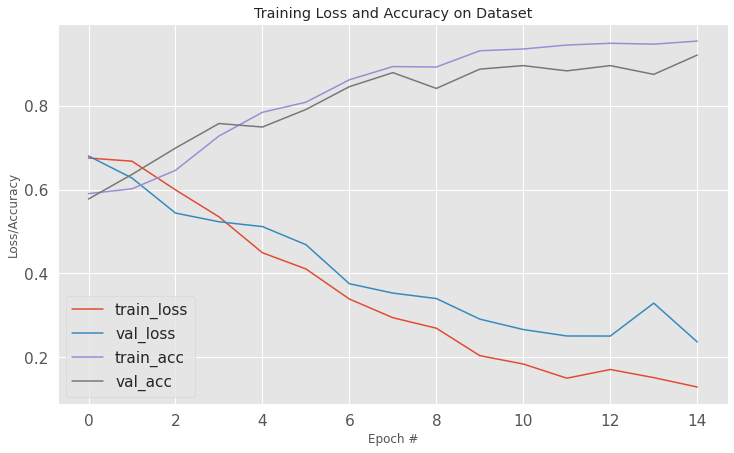

In [37]:
import torch, psutil


class MemoryUsage(keras.callbacks.Callback):

   def __init__(self):
      # setting device on GPU if available, else CPU
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      print('Using device for training:', self.device)
      self.max_RAM=[]
      self.max_GPU=[]

   def get_memory_usage(self):
      gpu_dict = tf.config.experimental.get_memory_info('GPU:0')
      print('\n GPU memory details [current: {} gb, peak: {} gb]'.format(
          float(gpu_dict['current']) / (1024 ** 3), 
          float(gpu_dict['peak']) / (1024 ** 3)))
   
   def get_size(self, byte, suffix="GB"):
    factor = 1024
    
    for unit in ["", "K", "M", "GB", "T", "P"]:
        if byte < factor:
            return f"{byte:.2f} GB"
        byte /= factor

   def on_train_end(self, epoch, logs=None):
      i=np.argmax(self.max_RAM)
      j=np.argmin(self.max_RAM)
      self.get_memory_usage()
      print("MAX RAM USAGE: %s / %s (%s)" % (self.get_size(self.max_RAM[i][0]), self.get_size(self.max_RAM[i][1]), str(self.max_RAM[i][2]) + "%" ))
      


   
   def on_epoch_end(self,epoch,logs=None):
      svmem = psutil.virtual_memory()
      self.max_RAM.append((svmem.active, svmem.total, svmem.percent))
      #self.get_memory_usage()
      
      
      
      


# initialize the optimizer and model
print("[INFO] compiling model...")


#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

#tf_seed()
#model = LiveNet((final_y,final_x,n_channels))
tf_seed()
#callback_early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
#memory_usage = MemoryUsage()

#в этом файле мы не используем перекрестную валидацию, поэтому сразу приступаем к созданию модели
model = Sequential()
#формируем модель из 6 сверточных слоев
model.add(Conv2D(16, 1, activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3),1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3),1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3),1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(512, (3,3),1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(GlobalAveragePooling2D())
#последний слой обобщающий, с функцией активации softmax и имеющий 2 выхода в итоге (то есть он показывает вероятность того или иного класса (оригинал/фейк))
model.add(Dense(2,activation='softmax'))

#optim = keras.optimizers.Adam(learning_rate=0.001)

#поскольку тут используется подход как к задаче многоклассовой классификации, тут используется функция потерь 'sparse_categorical_crossentropy' (кросс энтропия для категорий)
model.compile(optimizer="adam", 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

import time
start_time = time.time()

model.summary()

#тренируем модель
H = model.fit(train_images, train_labels, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=(test_images,test_labels),
                    #callbacks = [memory_usage, callback_early_stopping],
                    shuffle=True,
                    verbose=1
                    )

model.evaluate(test_images, test_labels)

print("TRAINING TIME","--- %s seconds ---" % round((time.time() - start_time),3))

#print("[INFO] serializing network to '{}'...".format(save_model_h5))
#model.save(save_model_h5, save_format="h5")

plot_accuracy_loss(H)

In [38]:

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools
from itertools import cycle
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

#model = tf.keras.models.load_model(save_model_h5)


#отображаем основные показатели метрик
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

print(classification_report(test_labels, pred_labels))

print(confusion_matrix(test_labels,pred_labels))
print()
tn, fp, fn, tp = confusion_matrix(list(test_labels), list(pred_labels), labels=[0, 1]).ravel()

print('True Positive', tp,'\nTrue Negative', tn,'\nFalse Positive', fp,'\nFalse Negative', fn)

from sklearn.metrics import accuracy_score

print('\nTPR', round(tp/(tp+fn),4))
print('FNR', round(fn/(fn+tp),4))
print('FPR', round(fp/(fp+tn),4))
print('TNR', round(tn/(tn+fp),4))
print('\nAccuracy:',round(accuracy_score(test_labels, pred_labels),4))
print('F1-score', round(2*tp/(2*tp+fp+fn),3))


              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       138
         1.0       0.87      0.95      0.91       101

    accuracy                           0.92       239
   macro avg       0.92      0.92      0.92       239
weighted avg       0.92      0.92      0.92       239

[[124  14]
 [  5  96]]

True Positive 96 
True Negative 124 
False Positive 14 
False Negative 5

TPR 0.9505
FNR 0.0495
FPR 0.1014
TNR 0.8986

Accuracy: 0.9205
F1-score 0.91


In [ ]:
test_loss = model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 52ms/step - loss: 0.5684 - accuracy: 0.7727


In [ ]:
#отображаем основные показатели метрик
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

         0.0       0.60      0.86      0.71         7
         1.0       0.92      0.73      0.81        15

    accuracy                           0.77        22
   macro avg       0.76      0.80      0.76        22
weighted avg       0.82      0.77      0.78        22



<Figure size 432x288 with 0 Axes>

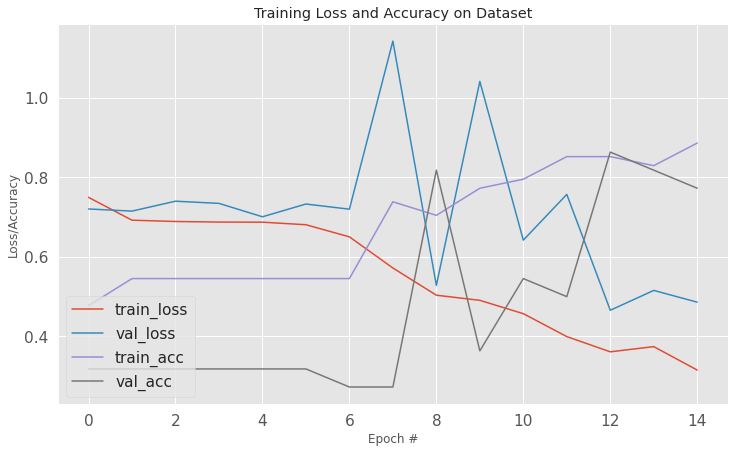

In [ ]:
#строим графики
plot_accuracy_loss(history)

In [ ]:
#сохраняем модель
model.save('forgery_model_not_kfold_50ep.h5') 